## ID : 170104059
## Dataset : 3
## Model : Bidirectional LSTM

In [1]:
import re
import spacy
import string


import en_core_web_sm
import tensorflow as tf

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn import model_selection, preprocessing

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

nlp = en_core_web_sm.load()
lemmatizer = WordNetLemmatizer()

FILTERS = '!"#$%&()*+,-/:;?@[\]^_`{|}~tn'
NUMBERING_PATTERN = re.compile('d+(?:st|[nr]d|th)')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import pandas as pd
import numpy as np
import csv
df = pd.read_csv("/content/Dataset 3.csv",encoding='latin1')
df

,tweets,sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [3]:
df['sentiment'].value_counts()

0    8000
1    2314
Name: sentiment, dtype: int64

In [4]:
df.drop_duplicates(inplace = True)
df

,tweets,sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [5]:
df.isnull().sum()

tweets       0
sentiment    0
dtype: int64

In [6]:
x = df.tweets.values
y = df.sentiment.values

## Train-test Splite

In [39]:
df = df.sample(frac = 1)

In [40]:
train_size = int(df.shape[0]*0.8)
X_train = df.tweets[:train_size]
Y_train = df.sentiment[:train_size]

X_test = df.tweets[train_size:]
Y_test = df.sentiment[train_size:]

In [41]:
X_train.shape

(8226,)

## Cleaning Dataset

In [42]:
from nltk.corpus import stopwords
puncset = list(string.punctuation)


In [43]:
def initial_preprocessing(text):

    numberings_removed_text =  NUMBERING_PATTERN.sub('', text)

    extra_chars_removed_text = re.sub(

        r"(.)1{2,}",  r'11', numberings_removed_text

    )

    return extra_chars_removed_text

In [44]:
X_train = X_train.apply(initial_preprocessing)

X_train = [
        lemmatizer.lemmatize(token)
        for token in X_train
    ]


texts_ = []
for text in X_train:
  words = [word.lower() for word in word_tokenize(text)]
  texts_.append(words)


puncsets = []
for token in texts_: 
    punc = [i for i in token if i not in puncset]
    puncsets.append(punc)
    

sentence = []
for token in puncsets: 
    word = [w for w in token if w.isalpha()]
    sentence.append(word)


english_stops = set(stopwords.words('english'))
filtered_words = []
for word in sentence: 
  f_word = [wd for wd in word if wd not in english_stops] 
  filtered_words.append(f_word)
   

texts_train = filtered_words

In [45]:
X_test = X_test.apply(initial_preprocessing)

X_test = [
        lemmatizer.lemmatize(token)
        for token in X_test
    ]

texts_ = []
for text in X_test:
  words = [word.lower() for word in word_tokenize(text)]
  texts_.append(words)


puncsets = []
for token in texts_: 
    punc = [i for i in token if i not in puncset]
    puncsets.append(punc)
    

sentence = []
for token in puncsets: 
    word = [w for w in token if w.isalpha()]
    sentence.append(word)


english_stops = set(stopwords.words('english'))
filtered_words = []
for word in sentence: 
  f_word = [wd for wd in word if wd not in english_stops] 
  filtered_words.append(f_word)

  
texts_test = filtered_words

In [46]:
labels = df['sentiment'].iloc[:]

In [22]:
num_word1 = len(texts_train)
num_word2 = len(texts_test)

## tokenize

In [47]:
tokenizer = Tokenizer(num_word1,filters = FILTERS)
tokenizer.fit_on_texts(texts_train)
x_train = tokenizer.texts_to_sequences(texts_train)
x_train = pad_sequences(
    x_train, 
    maxlen=128, 
    truncating = 'post',
    padding='post'
)

In [48]:
num_word = len(tokenizer.word_index)
num_word

15661

In [49]:
x_test = tokenizer.texts_to_sequences(texts_test)
x_test = pad_sequences(
    x_test, 
    maxlen=128, 
    truncating = 'post',
    padding='post'
)

In [52]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(Y_train)
y_test = le.transform(Y_test)

## Dataset Banalnce

In [53]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
#Random Over Sampling
ros = RandomOverSampler(random_state=777)
x_train, y_train = ros.fit_sample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [54]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
#Random Over Sampling
ros = RandomOverSampler(random_state=777)
x_test, y_test = ros.fit_sample(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [55]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(12818, 128) (12818,)
(3174, 128) (3174,)


## Model Making

In [56]:
model = Sequential()

model.add(Embedding(input_dim=num_word, output_dim=200, input_length=128,trainable = True))

model.add(Bidirectional(LSTM(200,dropout=0.2,return_sequences=True,)))

model.add(Bidirectional(LSTM(150,dropout=0.2,return_sequences=True,)))

model.add(Bidirectional(LSTM(100,dropout=0.2)))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 200)          3132200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 400)          641600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 300)          661200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 4,756,001
Trainable params: 4,756,001
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=15,
    verbose=True,
    batch_size = 30,
    validation_data=(x_test, y_test)
)

Epoch 1/15
428/428 [==============================] - 104s 209ms/step - loss: 0.0972 - accuracy: 0.9621 - val_loss: 0.1185 - val_accuracy: 0.9739
Epoch 2/15
428/428 [==============================] - 86s 202ms/step - loss: 0.0229 - accuracy: 0.9949 - val_loss: 0.1548 - val_accuracy: 0.9729
Epoch 3/15
428/428 [==============================] - 86s 201ms/step - loss: 0.0119 - accuracy: 0.9970 - val_loss: 0.1412 - val_accuracy: 0.9707
Epoch 4/15
428/428 [==============================] - 86s 201ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.1331 - val_accuracy: 0.9748
Epoch 5/15
428/428 [==============================] - 86s 201ms/step - loss: 0.0079 - accuracy: 0.9974 - val_loss: 0.1410 - val_accuracy: 0.9757
Epoch 6/15
428/428 [==============================] - 86s 201ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.1668 - val_accuracy: 0.9761
Epoch 7/15
428/428 [==============================] - 86s 201ms/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 0.1780 - val_a

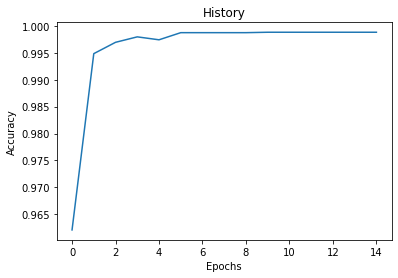

In [61]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['accuracy'])
title = plt.title("History")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

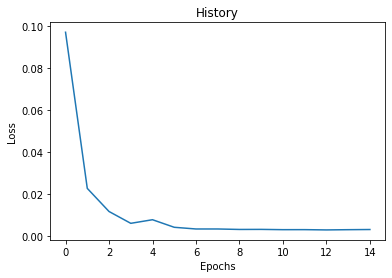

In [62]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['loss'])
title = plt.title("History")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Loss")

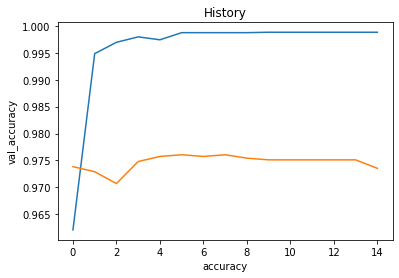

In [63]:
import matplotlib.pyplot as plt
fig1 = plt.plot(history.history['accuracy'])
fig2 = plt.plot(history.history['val_accuracy'])
title = plt.title("History")
xlabel = plt.xlabel("accuracy")
ylabel = plt.ylabel("val_accuracy")

## Prediction with text value

In [64]:
pred=model.predict(x_test)
for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0

In [ ]:
from sklearn.metrics import accuracy_score
accuracyScore = accuracy_score(y_test, pred)
print(accuracyScore)

0.983177570093458


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1605
           1       0.99      0.97      0.98      1605

    accuracy                           0.98      3210
   macro avg       0.98      0.98      0.98      3210
weighted avg       0.98      0.98      0.98      3210



For Bi-LSTM


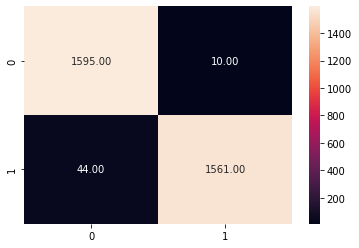

In [ ]:
from sklearn.metrics import confusion_matrix
bi_lstm_cm =confusion_matrix(y_test,pred)
import seaborn as sns
print("For Bi-LSTM")
sns.heatmap(bi_lstm_cm, annot=True,fmt='0.2f')

## Prediction with single line

In [ ]:
def predict_sentiment(test):
    texts_ = []
    for text in test:
      words = [word.lower() for word in word_tokenize(text)]
      texts_.append(words)

    puncsets = []
    for token in texts_: 
        punc = [i for i in token if i not in puncset]
        puncsets.append(punc)
        

    sentence = []
    for token in puncsets: 
        word = [w for w in token if w.isalpha()]
        sentence.append(word)

    english_stops = set(stopwords.words('english'))
    filtered_words = []
    for word in sentence: 
      f_word = [wd for wd in word if wd not in english_stops] 
      filtered_words.append(f_word)
 
    pre_texts = filtered_words
    
    X_predict = tokenizer.texts_to_sequences(pre_texts)
    X_predict = pad_sequences(
        X_predict, 
        maxlen=128, 
        truncating = 'post',
        padding='post'
    )

    
    print("Probability of positive: {}".format(model.predict(X_predict)[0]))
    return 0

In [ ]:
validation_sentence = ['woo. its late! haha  goodnight twitterverse! xoxo']
predict_sentiment(validation_sentence)
print(type(x))

Probability of positive: [0.99966633]
<class 'numpy.ndarray'>
